# ECE 4420/6420 Project 1 Submission Notebook
#### Jason Baer, Devin Lane, Richard Garcia, Aaron Bruner

## Part I - Dummy Submission
Here we create a baseline to compare our later models to.

In [85]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_validate,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [86]:
# For comparing our model scores
modelScores = {}

Read in the training data

In [87]:
space_df = pd.read_csv('./data/train.csv')
space_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Split the data into training and testing sets

In [88]:
# Split the dataset into training and testing data
train_df, test_df = train_test_split(space_df, test_size=.2, random_state=123)
X_train, y_train = train_df.drop(columns=['Transported']), train_df[['Transported']]
X_test, y_test = test_df.drop(columns=['Transported']), test_df[['Transported']]

Perform cross validation to get an idea of what our Dummy classifier can do

In [89]:
model = DummyClassifier(strategy='most_frequent')
# Carry out 5-fold cross-validation
pd.DataFrame(cross_validate(model, X_train, y_train, cv=5, return_train_score=True)).T

,0,1,2,3,4
fit_time,0.001995,0.000997,0.001030,0.000999,0.001996
score_time,0.000000,0.000998,0.000000,0.000000,0.000000
test_score,0.501797,0.501797,0.501797,0.501797,0.502158
train_score,0.501887,0.501887,0.501887,0.501887,0.501797


Fit our model to training data and predict the outcome:

In [90]:
# Redefine training dataframe to be entire train.csv file:
space_df = pd.read_csv('./data/train.csv')
X_train = space_df.drop(columns=['Transported'])
y_train = space_df[['Transported']]
model.fit(X_train, y_train)
# Score our model and save it to the dictionary:
modelScores['Dummy Most Frequent'] = model.score(X_test, y_test)

# Now we need to predict the outcomes of the unseen data:
# Read in the deploy (test) data:
space_deploy_df = pd.read_csv('./data/test.csv')
# Make our predictions:
dummyPredictions = model.predict(space_deploy_df)


Save our predictions to a csv file:

In [91]:
result = zip(space_deploy_df['PassengerId'], pd.Series(dummyPredictions))
out = pd.DataFrame(result, columns=['PassengerId', 'Transported']).sort_values('PassengerId')
out.to_csv('./results/dummyResult.csv', index=False)
out.describe()

,PassengerId,Transported
count,4277,4277
unique,4277,1
top,0013_01,True
freq,1,4277


## Part II - KNN

In [92]:
space_df = pd.read_csv('./data/train.csv')
spaceTest = pd.read_csv('./data/test.csv')

In [93]:
train_df, test_df = train_test_split(space_df, test_size=.2, random_state=123)
X_train, y_train = train_df.drop(columns=['Transported']), train_df[['Transported']]
X_test, y_test = test_df.drop(columns=['Transported']), test_df[['Transported']]

In [94]:
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']  
categorical_features = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
drop_features = ['PassengerId', 'Name']
target = 'Transported'

# Create our preprocessor
knn_preprocessor = make_column_transformer(
    # Apply standard scaling and imputation to our numeric features
    (make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), numeric_features),
    # Apply one-hot encoding and imputation to categorical features
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), categorical_features),
    # Drop our bad features
    ('drop', drop_features)
)

In [95]:
results_dict = {
    "neighbors": [],
    "train_accuracy": [],
    "cv_accuracy": [],
    "fit_time": [],
    "score_time": []
}

train_scores = []
test_scores = []
neighbors = []
#Find the best n_neighbors
for i in range(1, 30, 2):
    pipe_hyper_knn = make_pipeline(knn_preprocessor, KNeighborsClassifier(n_neighbors=i))
    pipe_hyper_knn.fit(X_train, y_train.values.ravel())
    scores = cross_validate(pipe_hyper_knn, X_train,y_train.values.ravel(), cv=5, return_train_score = True)

    results_dict["neighbors"].append(i)
    results_dict['train_accuracy'].append(np.mean(scores['train_score']))
    results_dict['cv_accuracy'].append(np.mean(scores['test_score']))
    results_dict['fit_time'].append(np.mean(scores['fit_time']))
    results_dict['score_time'].append(np.mean(scores['score_time']))

In [96]:
pd.DataFrame(results_dict)

,neighbors,train_accuracy,cv_accuracy,fit_time,score_time
0,1,0.999425,0.714842,0.025641,0.280205
1,3,0.858894,0.749929,0.029765,0.281919
2,5,0.833190,0.763734,0.027771,0.305839
3,7,0.818917,0.769197,0.023466,0.307712
4,9,0.812662,0.771786,0.029042,0.304421
5,11,0.808743,0.773080,0.025033,0.306925
6,13,0.805580,0.777683,0.022639,0.302904
7,15,0.802739,0.778258,0.022338,0.302269
8,17,0.800690,0.780270,0.025800,0.306152
9,19,0.799684,0.781852,0.024759,0.308529


,train_accuracy,cv_accuracy,fit_time,score_time
neighbors,,,,
1,0.999425,0.714842,0.025641,0.280205
3,0.858894,0.749929,0.029765,0.281919
5,0.833190,0.763734,0.027771,0.305839
7,0.818917,0.769197,0.023466,0.307712
9,0.812662,0.771786,0.029042,0.304421
11,0.808743,0.773080,0.025033,0.306925
13,0.805580,0.777683,0.022639,0.302904
15,0.802739,0.778258,0.022338,0.302269
17,0.800690,0.780270,0.025800,0.306152


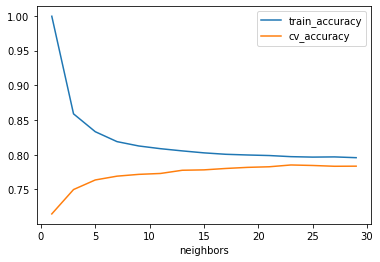

In [97]:
results_df = pd.DataFrame(results_dict)
results_df = results_df.set_index("neighbors")
results_df[["train_accuracy", "cv_accuracy"]].plot()
display(results_df)

In [98]:
#Best n_neighbors is 25
pipe_hyper_knn = make_pipeline(knn_preprocessor, KNeighborsClassifier(n_neighbors=25))
pipe_hyper_knn.fit(X_train, y_train.values.ravel())

X_test_predictions = pipe_hyper_knn.predict(X_test)
modelScores['kNN with Hyperparameter'] = pipe_hyper_knn.score(X_test, y_test)
display(modelScores['kNN with Hyperparameter'])

kNNPredictions = pipe_hyper_knn.predict(spaceTest)

0.7929844738355377

In [99]:
# Save our results in the proper format
result = zip(spaceTest['PassengerId'], pd.Series(kNNPredictions))
out = pd.DataFrame(result, columns=['PassengerId', 'Transported']).sort_values('PassengerId')
out.to_csv('./results/knn_with_25_hyperparameter.csv', index=False)
out.describe()

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,True
freq,1,2276


## Part III - Linear Regression with Preprocessing
Now that we have a baseline, we will introduce some preprocessing as well as test the performance of the K-Nearest Neighbors model against this baseline:

In [100]:
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
%matplotlib inline

### Step 1 - Redefine training and testing datasets just to avoid any leakage:

In [101]:
spaceTrain = pd.read_csv('./data/train.csv')
spaceTest = pd.read_csv('./data/test.csv')

### Step 2 - Exploratory Data Analysis

In [102]:
# Display some stats about our dataset:
spaceTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


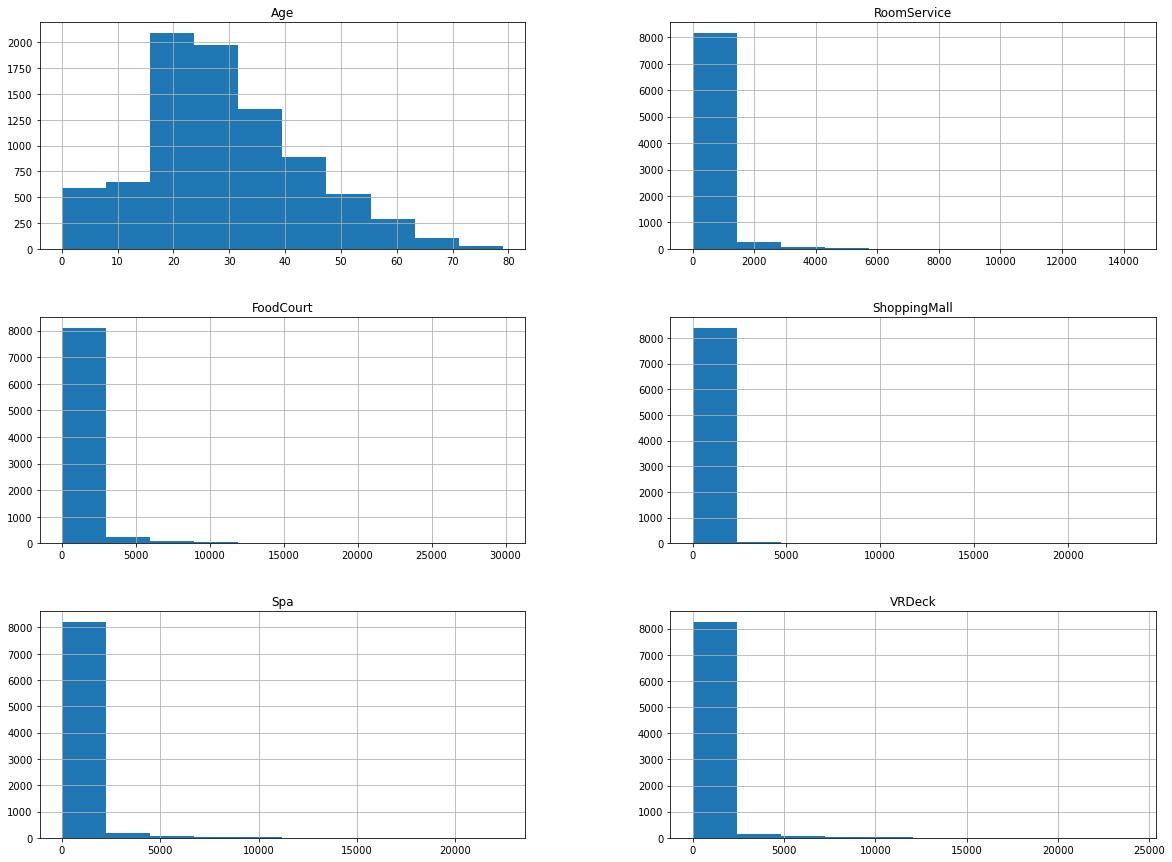

In [103]:
# Observe the distributions of our numerical features:
spaceTrain.hist(figsize=(20, 15));

### Step 3 - Preprocessing
A unique approach was taken in one part of this preprocessing. Aside from doing the usual column transformations provided by scikit-learn, an additional step was taken to manually split up the ```Cabin``` column into multiple columns - representative of each value between ```/``` in the original.
For example:
```B/0/P``` (one column) -----> ```B```   ```0``` ```P``` (three separate columns on same row).

This resulted in a higher training score than simply performing OHE on the original column.

In [104]:
# Let's deal with the slashes in the 'cabin' column first:
def cabinUpdate(df):
    # Split Cabin columns string on the slash and rename its columns
    cabinNew = df.Cabin.str.split('/', expand=True)
    cabinNew.columns = ['Cabin-1', 'Cabin-2', 'Cabin-3']
    # Copy the input dataframe to avoid mutating the original
    df1 = df.copy()
    # Add expanded columns to our copied dataframe:
    for col in cabinNew:
        df1[col] = cabinNew[col]
        print(cabinNew[col].value_counts())
    # Reorder the columns in the new dataframe:
    cols = df1.columns.tolist()
    cols = cols[:3] + cols[-3:] + cols[4:-3]
    df1 = df1[cols]
    return df1
# Update our DF's structure based on the Cabin column
spaceTrain = cabinUpdate(spaceTrain).copy()
# Split data into train and test
train_df, test_df = train_test_split(spaceTrain, test_size=.2, random_state=123)
X_train, y_train = train_df.drop(columns=['Transported']), train_df['Transported']
X_test, y_test = test_df.drop(columns=['Transported']), test_df['Transported']
X_train.head()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Cabin-1, dtype: int64
82      28
86      22
19      22
56      21
176     21
        ..
1644     1
1515     1
1639     1
1277     1
1894     1
Name: Cabin-2, Length: 1817, dtype: int64
S    4288
P    4206
Name: Cabin-3, dtype: int64


,PassengerId,HomePlanet,CryoSleep,Cabin-1,Cabin-2,Cabin-3,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
7074,7527_01,Earth,False,F,1561,P,TRAPPIST-1e,18.0,False,0.0,732.0,2.0,13.0,47.0,Elle Flowensley
6710,7083_01,Europa,True,C,259,S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,Betenar Pirejus
2569,2755_01,Europa,True,B,85,P,55 Cancri e,36.0,False,0.0,0.0,0.0,0.0,0.0,Beneba Glousspidy
3850,4127_01,Europa,NaN,B,130,P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,NaN,Dsch Ainserfle
7450,7972_02,Europa,False,B,260,P,TRAPPIST-1e,35.0,False,NaN,246.0,25.0,42.0,3730.0,Atinon Cattyried


In [105]:
# Define our categories of columns:
cat = ['HomePlanet',  'Cabin-1', 'Cabin-3', 'Destination']
num = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin-2']
binary = ['CryoSleep', 'VIP']
drop = ['Name']
target = 'Transported'
# Make the column transformer:
preprocessor = make_column_transformer(
        # Apply standard scaling to all our numeric features
        (make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), num),
        # Make a pipeline for our categorical features
        # 1. First fill NaN's with most frequent of each feature
        # 2. Then use one hot encoding on result
        (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), cat),
        # One-hot encoding of our binary column, 'sex,' so we aren't wasting space
        (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary", dtype=int,handle_unknown='ignore')), binary),
        ('drop', drop)
)

In [106]:
# make our pipeline with the preprocessor and logistic regression
pipe = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter = 10000),
)
# Display cross-validation scores
scores = cross_validate(pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.074821,0.009101,0.812365,0.785907
1,0.075630,0.007980,0.782890,0.794535
2,0.052929,0.010023,0.776420,0.791659
3,0.060222,0.008976,0.791517,0.788424
4,0.056867,0.011030,0.784173,0.790259


### Step 4 - Hyperparameter Optimization
Let's see if we can get our score up by optimizing our hyperparameter:

In [107]:
param_grid = {
    'logisticregression__C': 10.0 ** np.arange(-20, 10)
}

gridSearch = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True)

from sklearn import set_config
set_config(display='diagram')

# Conveniently we can fit the GridSearch returned model on our data
gridSearch.fit(X_train, y_train)
display(gridSearch)
# Show the best score:
display(gridSearch.best_score_)
# Show the best hyperparameter:
display(gridSearch.best_params_)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'Cabin-2']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_...
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-20, 1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13,
       1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
       1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])},
             return_train_score=True)

0.7903356107349923

{'logisticregression__C': 10.0}

Now we know to set C = 1 for our hyperparameter. Let's try this in our model: (note this is the default so the grid search didn't help much)

### Step 5 - Scoring our Finalized Model

In [108]:
# Redefine pipeline
pipe = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter = 1000, C=1),
)
# Fit the pipeline on our training data
pipe.fit(X_train, y_train)
# Score it on our validation data:
modelScores['Logistic Regression'] = pipe.score(X_test, y_test)
display(modelScores['Logistic Regression'])

0.8062104657849338

### Step 6 - Make and Save Our Predictions for Submission
This score looks pretty good. Let's try predicting values for submission to the competition:

In [109]:
# Now fit our pipeline on the entire training set:
X_train, y_train = spaceTrain.drop(columns=['Transported']), spaceTrain[['Transported']]
pipe.fit(X_train, y_train)
# Manual transformation
spaceTest = cabinUpdate(spaceTest).copy()
# Make our predictions:
spaceshipPredictions = pipe.predict(spaceTest)

F    1445
G    1222
E     447
B     362
C     355
D     242
A      98
T       6
Name: Cabin-1, dtype: int64
4       21
31      18
197     16
294     16
228     14
        ..
1170     1
904      1
1174     1
356      1
1503     1
Name: Cabin-2, Length: 1505, dtype: int64
S    2093
P    2084
Name: Cabin-3, dtype: int64


C:\Users\jmbaer\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [110]:
# Save our results in the proper format
result = zip(spaceTest['PassengerId'], pd.Series(spaceshipPredictions))
out = pd.DataFrame(result, columns=['PassengerId', 'Transported']).sort_values('PassengerId')
out.to_csv('./results/lrWithCabinResult.csv', index=False)
out.describe()

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,True
freq,1,2260


## Large Trees

### Random Forest

In [111]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123, n_jobs=-1))
pipe_rf.fit(X_train,y_train.values.ravel())
modelScores["Random forests"] = pipe_rf.score(X_test,y_test.values.ravel())

In [112]:
# Make our predictions:
spaceshipPredictions = pipe_rf.predict(spaceTest)
result = zip(spaceTest['PassengerId'], pd.Series(spaceshipPredictions))
out = pd.DataFrame(result, columns=['PassengerId', 'Transported']).sort_values('PassengerId')
out.to_csv('./results/random_forest.csv', index=False)
out.describe()

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,False
freq,1,2292


### XGBOOST

In [113]:
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0))
pipe_xgb.fit(X_train,y_train.values.ravel())
# Manual transformation
modelScores["XGBOOST"] = pipe_xgb.score(X_test,y_test.values.ravel())
# Make our predictions:
spaceshipPredictions = pipe_xgb.predict(spaceTest)

C:\Users\jmbaer\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [114]:
result = zip(spaceTest['PassengerId'], pd.Series(spaceshipPredictions))
out = pd.DataFrame(result, columns=['PassengerId', 'Transported']).sort_values('PassengerId')
out.to_csv('./results/xgboost.csv', index=False)
out.describe()

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,False
freq,1,2141


### Cat Boost

In [115]:
pipe_catboost = make_pipeline(preprocessor, CatBoostClassifier(verbose=0, random_state=123))
pipe_catboost.fit(X_train,y_train)
#modelScores["Cat Boost"] = pipe_catboost.score(X_test,y_test)
# above gives error: "predicted classes have string type but specified y is boolean"
spaceshipPredictions = pipe_catboost.predict(spaceTest)

In [116]:
result = zip(spaceTest['PassengerId'], pd.Series(spaceshipPredictions))
out = pd.DataFrame(result, columns=['PassengerId', 'Transported']).sort_values('PassengerId')
out.to_csv('./results/catboost.csv', index=False)
out.describe()

,PassengerId,Transported
count,4277,4277
unique,4277,2
top,0013_01,True
freq,1,2189


## Part X: Compare Scores of Different Models (on train and test split, not deployment data):

In [117]:
df = pd.DataFrame.from_dict(modelScores, orient='index')
df.columns = ['Score']
df

,Score
Dummy Most Frequent,0.510638
kNN with Hyperparameter,0.792984
Logistic Regression,0.806210
Random forests,1.000000
XGBOOST,0.934445
